In [2]:
# ----------------------
# Módulo 1: Importações
# ----------------------
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
from collections import Counter
import numpy as np
from math import log
import seaborn as sns
import matplotlib.patheffects as path_effects
from adjustText import adjust_text
from pyvis.network import Network
from networkx.drawing.nx_agraph import graphviz_layout

In [3]:
# ----------------------
# Módulo 2: Carregar o grafo
# ----------------------
caminho_arquivo = r"C:\Users\cesar\OneDrive\Documentos\NOVA - NII\Projeto_grafo_Vacina_NII\mencoes_saude_10042025_15042025.gexf"
grafo = nx.read_gexf(caminho_arquivo)

print(f"Número de nós: {grafo.number_of_nodes()}")
print(f"Número de arestas: {grafo.number_of_edges()}")


Número de nós: 3226
Número de arestas: 4427


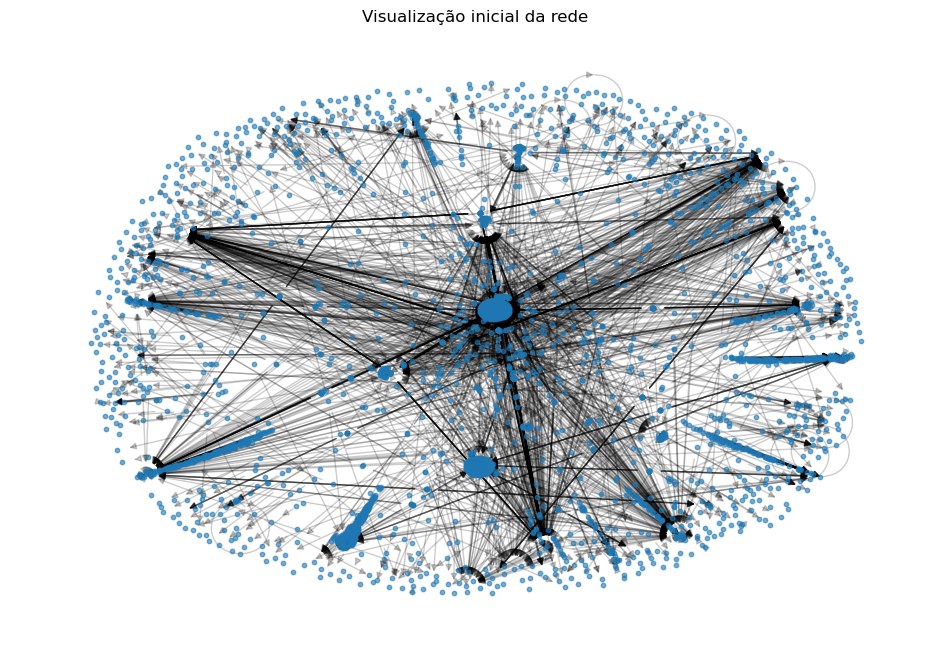

In [4]:
# ----------------------
# Módulo 3: Visualização exploratória
# ----------------------
plt.figure(figsize=(12, 8))
posicionamento = nx.spring_layout(grafo, seed=42)
nx.draw_networkx_nodes(grafo, posicionamento, node_size=10, alpha=0.6)
nx.draw_networkx_edges(grafo, posicionamento, alpha=0.2)
plt.title("Visualização inicial da rede")
plt.axis("off")
plt.show()

In [5]:
# ----------------------
# Módulo 4: Métricas básicas
# ----------------------
print(f"É grafo direcionado? {nx.is_directed(grafo)}")

grau_entrada = grafo.in_degree() if nx.is_directed(grafo) else grafo.degree()
grau_entrada_dict = dict(grau_entrada)

# Top 10 perfis mais mencionados
top_10_mais_mencionados = sorted(grau_entrada_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 perfis mais mencionados ou retweetados:")
for id_no, grau in top_10_mais_mencionados:
    print(f"{id_no}: {grau}")

É grafo direcionado? True
Top 10 perfis mais mencionados ou retweetados:
1193: 457
166: 290
14: 281
208: 275
59: 245
488: 222
193: 178
2844: 176
171: 158
319: 154


In [6]:
# ----------------------
# Módulo 5: Inspecionar atributos dos nós
# ----------------------
id_exemplo = top_10_mais_mencionados[0][0]
print(f"Atributos do nó {id_exemplo}: {grafo.nodes[id_exemplo]}")

atributos_exemplo = list(grafo.nodes(data=True))[0][1].keys()
print(f"Atributos disponíveis nos nós: {list(atributos_exemplo)}")

Atributos do nó 1193: {'postagens': 3, 'mencoes': 495, 'seguidores': 0, 'label': 'kriskacarvalho'}
Atributos disponíveis nos nós: ['postagens', 'mencoes', 'seguidores', 'label']


In [7]:
# ----------------------
# Módulo 6: Criar DataFrame com os nós
# ----------------------
dados_nos = [
    {"id": no, **atributos} for no, atributos in grafo.nodes(data=True)
]

df_nos = pd.DataFrame(dados_nos)
df_nos = df_nos.sort_values(by="mencoes", ascending=False)

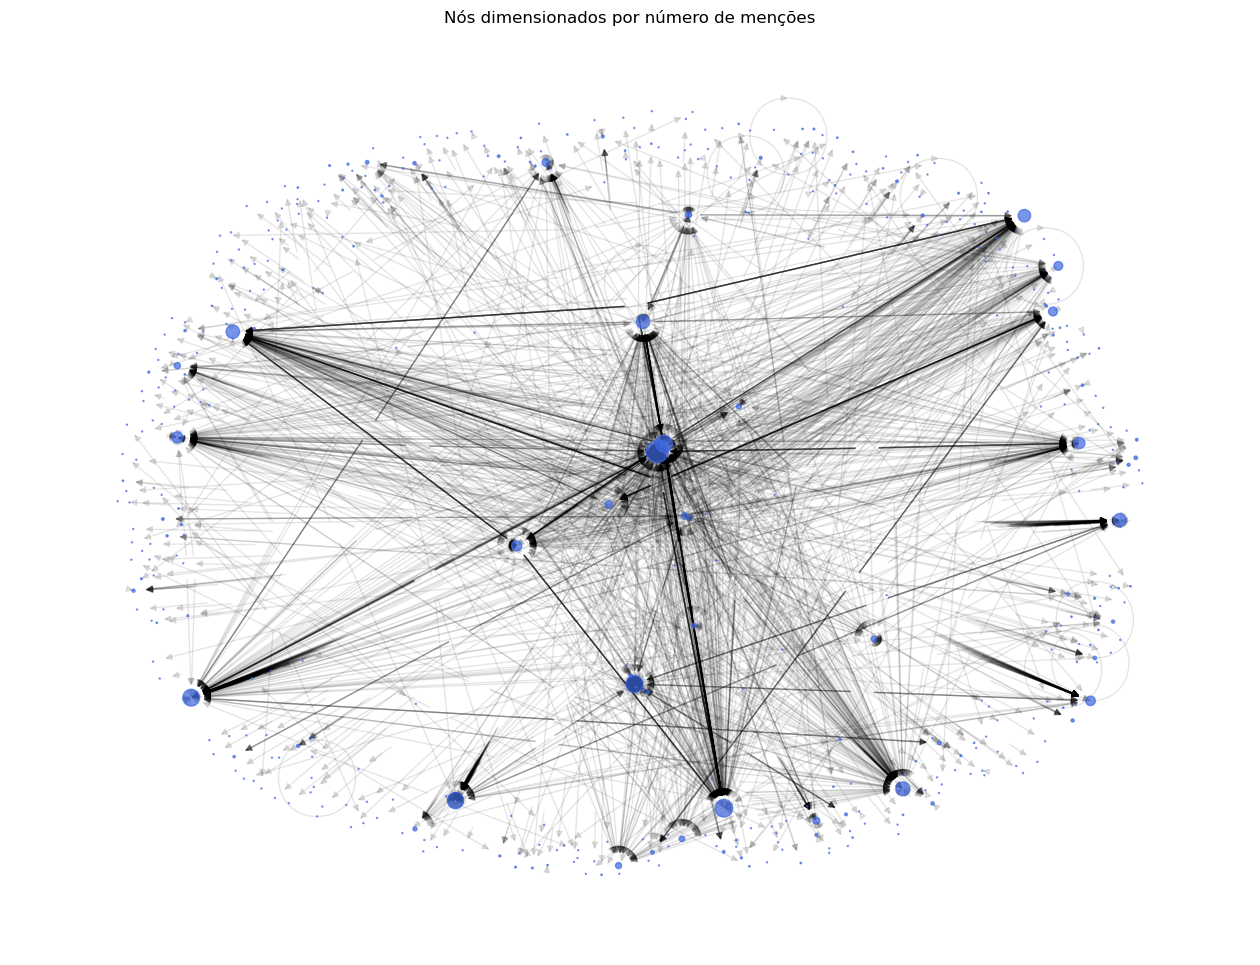

In [8]:
# ----------------------
# Módulo 7: Visualização com tamanho por menções
# ----------------------
posicionamento = nx.spring_layout(grafo, seed=42)
tamanho_nos = [df_nos.set_index("id").get("mencoes").get(no, 0) * 0.5 for no in grafo.nodes()]

plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(grafo, posicionamento, node_size=tamanho_nos, alpha=0.7, node_color="royalblue")
nx.draw_networkx_edges(grafo, posicionamento, alpha=0.1)
plt.title("Nós dimensionados por número de menções")
plt.axis("off")
plt.show()


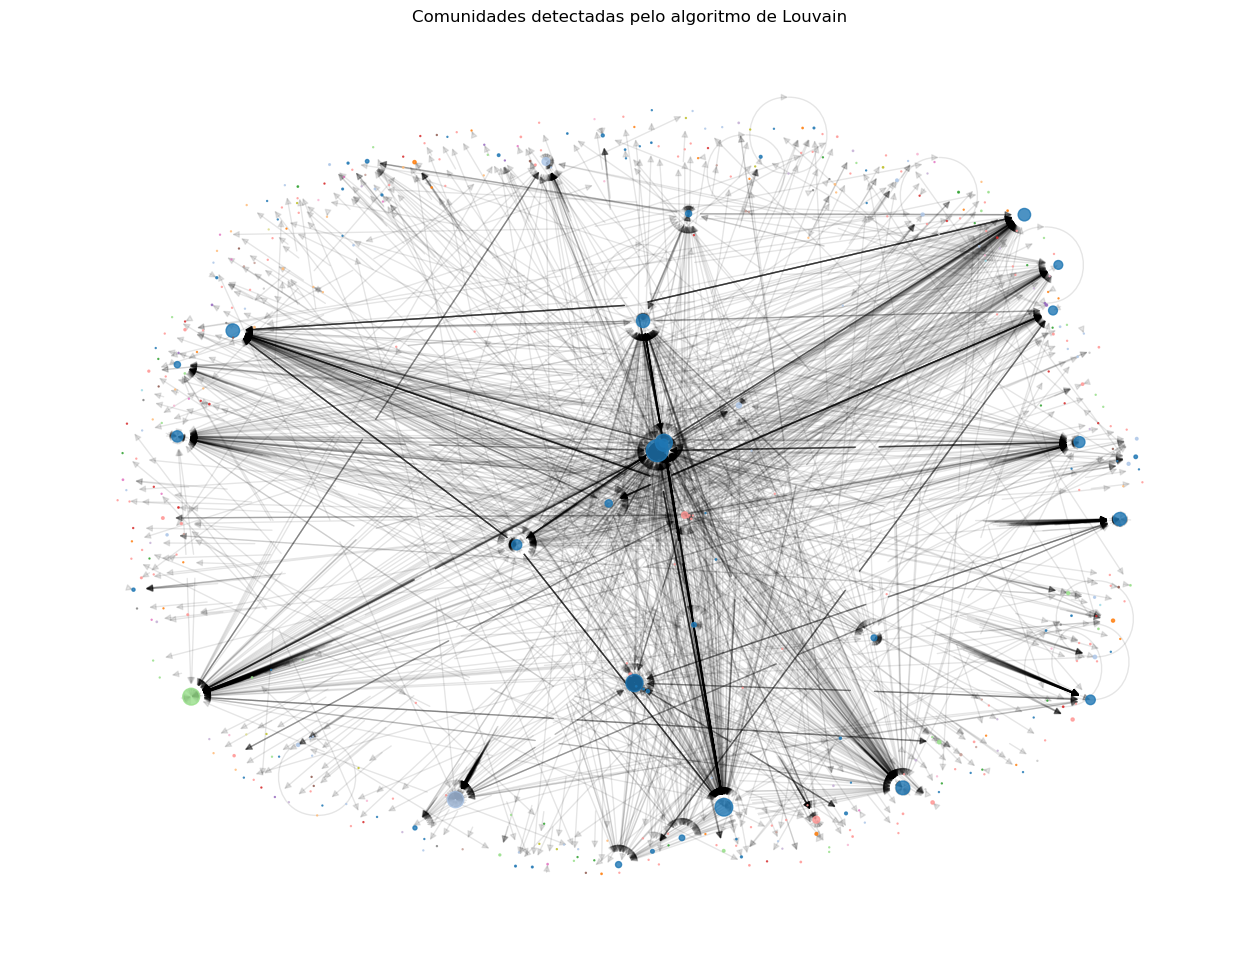

In [9]:
# ----------------------
# Módulo 8: Clusterização com Louvain
# ----------------------
grafo_nao_direcionado = grafo.to_undirected()
comunidades = community_louvain.best_partition(grafo_nao_direcionado)

cores_comunidades = [comunidades.get(no, 0) for no in grafo.nodes()]

plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(grafo, posicionamento, node_color=cores_comunidades, node_size=tamanho_nos, alpha=0.8, cmap=plt.cm.tab20)
nx.draw_networkx_edges(grafo, posicionamento, alpha=0.1)
plt.title("Comunidades detectadas pelo algoritmo de Louvain")
plt.axis("off")
plt.show()

In [10]:
# ----------------------
# Módulo 9: Tamanho das comunidades
# ----------------------
contagem_comunidades = Counter(comunidades.values())
print(f"Número de comunidades detectadas: {len(contagem_comunidades)}")
print("Tamanho das maiores comunidades:")
for id_comunidade, qtd in contagem_comunidades.most_common(10):
    print(f"Comunidade {id_comunidade}: {qtd} nós")


Número de comunidades detectadas: 410
Tamanho das maiores comunidades:
Comunidade 0: 332 nós
Comunidade 6: 308 nós
Comunidade 34: 274 nós
Comunidade 4: 270 nós
Comunidade 103: 235 nós
Comunidade 160: 180 nós
Comunidade 3: 177 nós
Comunidade 2: 162 nós
Comunidade 9: 144 nós
Comunidade 12: 103 nós


In [11]:
# ----------------------
# Módulo 10: Top perfis por comunidade
# ----------------------
df_nos["comunidade"] = df_nos["id"].map(comunidades)

top_por_comunidade = (
    df_nos.groupby("comunidade")
    .apply(lambda grupo: grupo.sort_values("mencoes", ascending=False).head(1))
    .reset_index(drop=True)
)

top_por_comunidade = top_por_comunidade.sort_values("mencoes", ascending=False)
print("Top perfis das principais comunidades:")
print(top_por_comunidade.head(10))

Top perfis das principais comunidades:
       id  postagens  mencoes  seguidores            label  comunidade
0    1193          3      495           0   kriskacarvalho           0
6      59          1      322           0       padilhando           6
4      14         11      302           0    saray_sandrac           4
103   166          1      293           0       brunoguzz0         103
34    208          1      276           0       louh_novak          34
2     193          0      193           0            govbr           2
3    2844          0      176           0     mpmissao21_1           3
18     26          1      130           0  senadorhumberto          18
9    1450          0      124           0    pedrorousseff           9
14    725          1      106           0  rogeriocorreia_          14


C:\Users\cesar\AppData\Local\Temp\ipykernel_36724\3030191411.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grupo: grupo.sort_values("mencoes", ascending=False).head(1))


In [12]:
# ----------------------
# Módulo 11: Centralidade de intermediação
# ----------------------
intermediacao = nx.betweenness_centrality(grafo.to_undirected())
df_nos["intermediacao"] = df_nos["id"].map(intermediacao)

print("Perfis com maior centralidade de intermediação:")
print(df_nos.sort_values("intermediacao", ascending=False).head(10))

Perfis com maior centralidade de intermediação:
        id  postagens  mencoes  seguidores           label  comunidade  \
2410    14         11      302           0   saray_sandrac           4   
2093  1193          3      495           0  kriskacarvalho           0   
332    166          1      293           0      brunoguzz0         103   
785     98         63       43           0            grok         160   
845    208          1      276           0      louh_novak          34   
138    414          0       82           0     lulaoficial           6   
1523   168          6        0        1579    silbatista68           6   
3210   767          1        7           0       cnnbrasil          34   
2277    99          1        7           0      mlucchinni         160   
2847   689          1       13           0  filipe_rafaeli         103   

      intermediacao  
2410       0.191895  
2093       0.164032  
332        0.146711  
785        0.146012  
845        0.134746  
138  

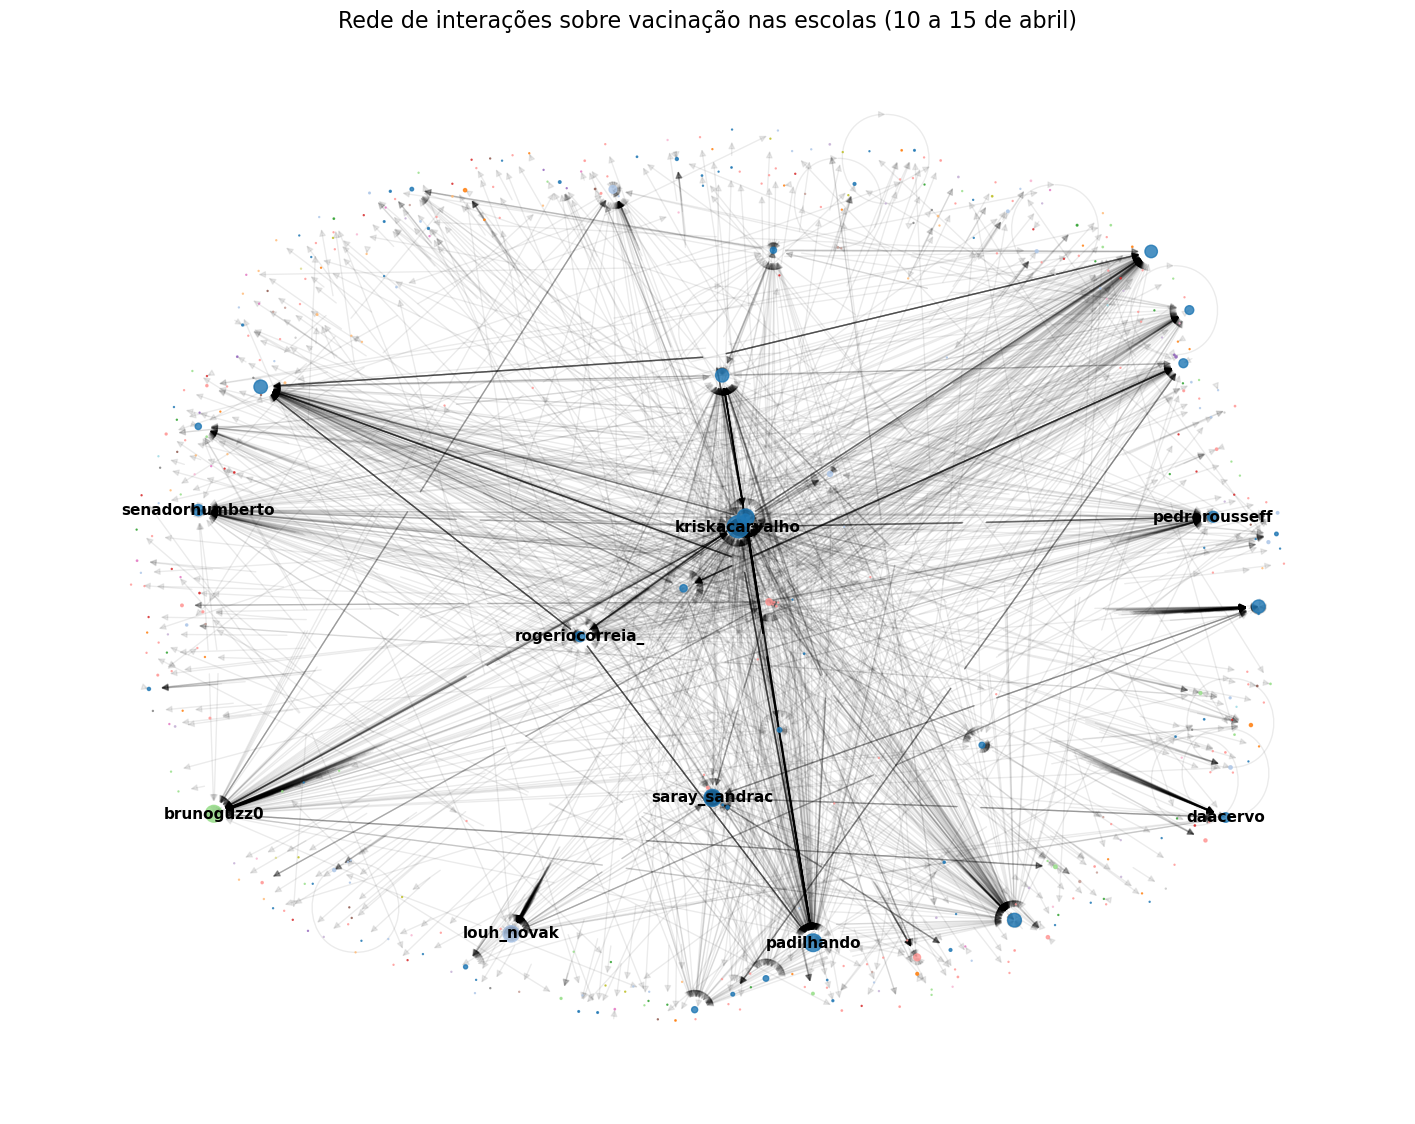

In [13]:
# ----------------------
# Módulo 12: Visualização com destaques qualitativos
# ----------------------

# Lista dos perfis que você analisou (podemos expandir se quiser)
perfis_destacados = [
    "louh_novak",
    "kriskacarvalho",
    "padilhando",
    "brunoguzz0",
    "saray_sandrac",
    "senadorhumberto",
    "pedrorousseff",
    "rogeriocorreia_",
    "daacervo"
]

# Criar dicionário de labels apenas para perfis selecionados
rotulos_destacados = {
    no: dados["label"]
    for no, dados in grafo.nodes(data=True)
    if dados.get("label") in perfis_destacados
}

# Plotando
plt.figure(figsize=(18, 14))

# Nós (cores por comunidade, tamanhos por menções)
nx.draw_networkx_nodes(
    grafo,
    pos=posicionamento,
    node_color=cores_comunidades,
    node_size=tamanho_nos,
    alpha=0.8,
    cmap=plt.cm.tab20
)

# Arestas
nx.draw_networkx_edges(grafo, pos=posicionamento, alpha=0.08)

# Labels apenas nos perfis selecionados
nx.draw_networkx_labels(
    grafo,
    pos=posicionamento,
    labels=rotulos_destacados,
    font_size=11,
    font_weight="bold"
)

plt.title("Rede de interações sobre vacinação nas escolas (10 a 15 de abril)", fontsize=16)
plt.axis("off")

# Opcional: salvar imagem
# plt.savefig("rede_vacinacao_destaques.png", dpi=300, bbox_inches="tight")

plt.show()


In [14]:
# ----------------------
# Módulo 13: Assortatividade (homofilia por atributo)
# ----------------------
def calcular_assortatividade_por_atributo(grafo, atributo):
    """Calcula o coeficiente de assortatividade para um atributo específico dos nós."""
    if not nx.get_node_attributes(grafo, atributo):
        print(f"Atributo '{atributo}' não encontrado nos nós.")
        return None
    return nx.attribute_assortativity_coefficient(grafo, atributo)

assortatividade_label = calcular_assortatividade_por_atributo(grafo.to_undirected(), "label")
print(f"Coeficiente de assortatividade por 'label': {assortatividade_label:.2f}")


Coeficiente de assortatividade por 'label': -0.01


In [15]:
# ----------------------
# Módulo 14: Identificação de pontes entre comunidades
# ----------------------
def identificar_pontes_entre_comunidades(grafo, df_nos, comunidades):
    """Identifica nós que atuam como pontes entre diferentes comunidades."""
    def eh_ponte(row):
        return any(comunidades.get(vizinho) != row["comunidade"] for vizinho in grafo.neighbors(row["id"]))
    return df_nos[df_nos.apply(eh_ponte, axis=1)]

pontes = identificar_pontes_entre_comunidades(grafo, df_nos, comunidades)
print("Exemplos de perfis que atuam como pontes entre comunidades:")
print(pontes[["label", "comunidade", "mencoes"]].head(10))


Exemplos de perfis que atuam como pontes entre comunidades:
                label  comunidade  mencoes
2093   kriskacarvalho           0      495
2348       padilhando           6      322
2410    saray_sandrac           4      302
3014  rogeriocorreia_          14      106
785              grok         160       43
1132         ptbrasil           2       39
1857    sandraselmasr          32       27
3124      ldrsilva294           0       22
2277       mlucchinni         160        7
102       renata_vasq          12        5


In [16]:
# ----------------------
# Módulo 15: Análise de pesos nas arestas
# ----------------------

def calcular_grau_ponderado(grafo):
    """Retorna uma lista de pesos para as arestas com base no atributo 'weight'."""
    if 'weight' not in list(grafo.edges(data=True))[0][2]:
        print("Arestas não possuem o atributo 'weight'.")
        return None
    return [d['weight'] for (_, _, d) in grafo.edges(data=True)]

pesos_arestas = calcular_grau_ponderado(grafo)

In [17]:
# ----------------------
# Módulo 16: Tamanho das comunidades em DataFrame
# ----------------------

def obter_tamanho_comunidades(comunidades):
    """Retorna o tamanho de cada comunidade em um DataFrame ordenado."""
    contagem = Counter(comunidades.values())
    df = pd.DataFrame.from_dict(contagem, orient='index', columns=['tamanho']).reset_index()
    df = df.rename(columns={'index': 'comunidade'})
    return df.sort_values(by='tamanho', ascending=False)

tamanhos_comunidades = obter_tamanho_comunidades(comunidades)
print("Top 5 comunidades por tamanho:")
print(tamanhos_comunidades.head())

Top 5 comunidades por tamanho:
   comunidade  tamanho
0           0      332
6           6      308
1          34      274
4           4      270
5         103      235


In [18]:
# ----------------------
# Módulo 17: Top N perfis por comunidade (parametrizável)
# ----------------------
def top_nos_por_comunidade(df_nos, comunidades, n=1):
    """Retorna os top nós com mais menções por comunidade."""
    df_nos["comunidade"] = df_nos["id"].map(comunidades)
    return (
        df_nos.groupby("comunidade")
        .apply(lambda grupo: grupo.sort_values("mencoes", ascending=False).head(n))
        .reset_index(drop=True)
        .sort_values("mencoes", ascending=False)
    )

top_3_por_comunidade = top_nos_por_comunidade(df_nos, comunidades, n=3)
print("Top 3 perfis por comunidade:")
print(top_3_por_comunidade[["label", "comunidade", "mencoes"]].head(10))

Top 3 perfis por comunidade:
               label  comunidade  mencoes
0     kriskacarvalho           0      495
14        padilhando           6      322
10     saray_sandrac           4      302
15          canalgov           6      299
214       brunoguzz0         103      293
75        louh_novak          34      276
4              govbr           2      193
16   camilosantanace           6      188
7       mpmissao21_1           3      176
40   senadorhumberto          18      130


C:\Users\cesar\AppData\Local\Temp\ipykernel_36724\1859050569.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grupo: grupo.sort_values("mencoes", ascending=False).head(n))


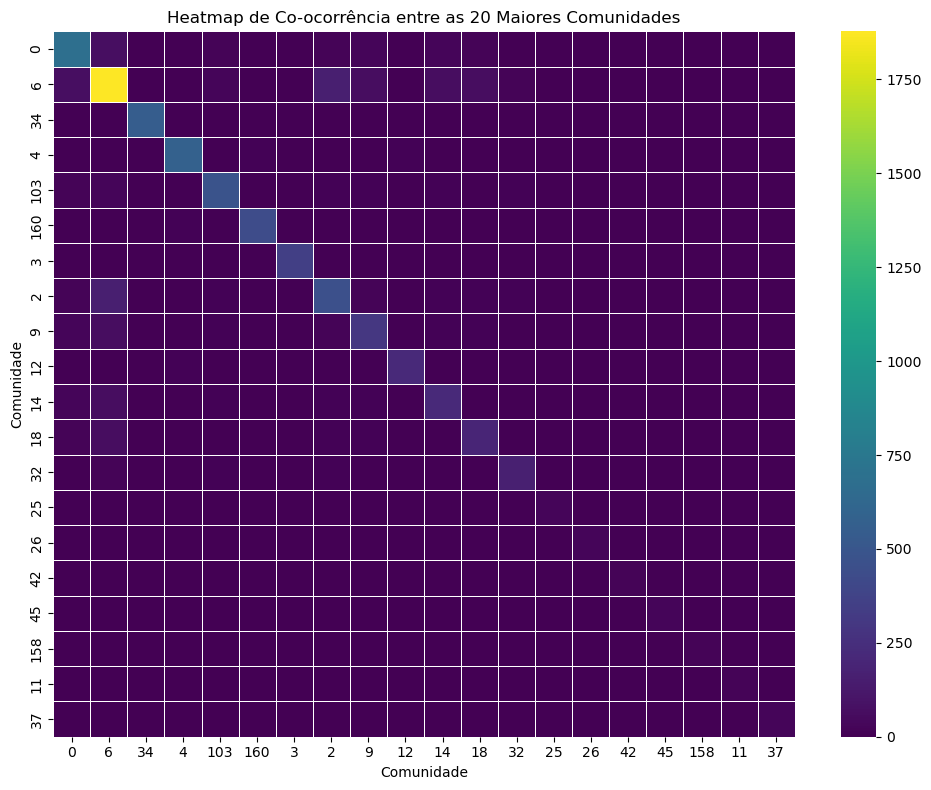

In [19]:
# ----------------------
# Módulo 18: Heatmap entre as 20 maiores comunidades
# ----------------------

def matriz_coocorrencia_comunidades_filtrada(grafo, comunidades, top_n=20):
    """Gera matriz de co-ocorrência entre as top_n maiores comunidades."""
    # Contar tamanho das comunidades
    contagem = Counter(comunidades.values())
    top_comunidades = [com for com, _ in contagem.most_common(top_n)]
    
    # Criar dicionário de índice
    idx_map = {com: i for i, com in enumerate(top_comunidades)}
    matriz_np = np.zeros((top_n, top_n))

    # Preencher matriz com co-ocorrência de arestas entre as top_n comunidades
    for u, v in grafo.edges():
        cu, cv = comunidades.get(u), comunidades.get(v)
        if cu in idx_map and cv in idx_map:
            i, j = idx_map[cu], idx_map[cv]
            matriz_np[i, j] += 1
            matriz_np[j, i] += 1  # simetria

    return matriz_np, top_comunidades

# Executar
matriz_filtrada, comunidades_top = matriz_coocorrencia_comunidades_filtrada(grafo, comunidades, top_n=20)

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_filtrada, xticklabels=comunidades_top, yticklabels=comunidades_top, cmap="viridis", linewidths=0.5)
plt.title("Heatmap de Co-ocorrência entre as 20 Maiores Comunidades")
plt.xlabel("Comunidade")
plt.ylabel("Comunidade")
plt.tight_layout()
plt.show()

C:\Users\cesar\AppData\Local\Temp\ipykernel_36724\3922871389.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values("intermediacao", ascending=False).head(1))


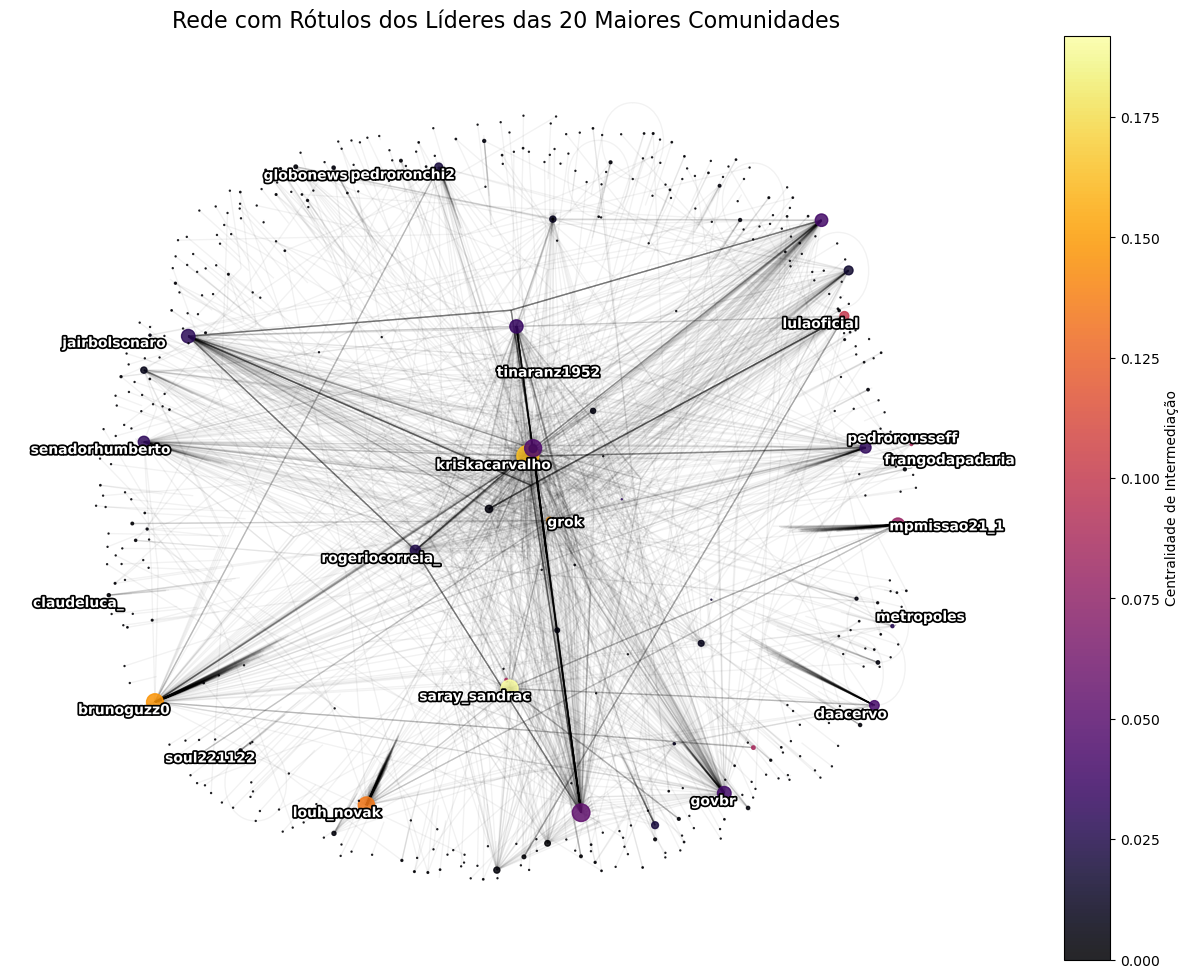

In [25]:
# ----------------------
# Módulo 19: Visualização com Intermediação (20 maiores comunidades com rótulos)
# ----------------------

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from adjustText import adjust_text
from collections import Counter

def visualizar_por_intermediacao(grafo, df_nos, posicionamento, comunidades, salvar=False, n_comunidades=20):
    """Visualiza a rede com rótulos dos líderes das maiores comunidades com ajuste automático."""

    grafo_visual = grafo.to_undirected()

    # Calcular intermediação
    intermediacao = nx.betweenness_centrality(grafo_visual, normalized=True)
    df_nos["intermediacao"] = df_nos["id"].map(intermediacao)
    df_nos["comunidade"] = df_nos["id"].map(comunidades)

    intermediacao_normalizada = [intermediacao.get(no, 0.0) for no in grafo.nodes()]
    tamanho_nos = [df_nos.set_index("id").get("mencoes").get(no, 0) * 0.5 for no in grafo.nodes()]

    # Selecionar as N maiores comunidades
    maiores_comunidades = df_nos["comunidade"].value_counts().head(n_comunidades).index.tolist()

    # Selecionar 1 perfil com maior intermediação por comunidade
    top_por_comunidade = (
        df_nos[df_nos["comunidade"].isin(maiores_comunidades)]
        .groupby("comunidade")
        .apply(lambda g: g.sort_values("intermediacao", ascending=False).head(1))
        .reset_index(drop=True)
    )

    rotulos_destacados = {
        no: dados["label"]
        for no, dados in grafo.nodes(data=True)
        if dados.get("label") in top_por_comunidade["label"].values
    }

    # Plot
    plt.figure(figsize=(16, 12))
    nodes = nx.draw_networkx_nodes(
        grafo_visual,
        pos=posicionamento,
        node_color=intermediacao_normalizada,
        node_size=tamanho_nos,
        alpha=0.85,
        cmap=plt.cm.inferno
    )
    nx.draw_networkx_edges(grafo_visual, pos=posicionamento, alpha=0.05)

    # Rótulos com ajuste automático
    textos = []
    for no, label in rotulos_destacados.items():
        x, y = posicionamento[no]
        txt = plt.text(
            x, y, label,
            fontsize=10,
            fontweight="bold",
            color="white",
            ha="center",
            va="center",
            zorder=10
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=2.5, foreground='black'),
            path_effects.Normal()
        ])
        textos.append(txt)

    adjust_text(textos, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

    plt.colorbar(nodes, label="Centralidade de Intermediação")
    plt.title("Rede com Rótulos dos Líderes das 20 Maiores Comunidades", fontsize=16)
    plt.axis("off")

    if salvar:
        plt.savefig("rede_intermediacao_maiores_comunidades.png", dpi=300, bbox_inches="tight")

    plt.show()

# Execução
visualizar_por_intermediacao(grafo, df_nos, posicionamento, comunidades)


In [26]:
# ----------------------
# Módulo 20 (alternativo): Layout com Graphviz - estilo OpenOrd
# ----------------------

def gerar_posicionamento_graphviz(grafo, prog="sfdp"):
    """
    Gera layout com Graphviz. Usa 'sfdp' como algoritmo (bom para grafos grandes).
    """
    grafo_nao_direcionado = grafo.to_undirected()
    return graphviz_layout(grafo_nao_direcionado, prog=prog)

# Execução
posicionamento_graphviz = gerar_posicionamento_graphviz(grafo)


In [ ]:
# ----------------------
# Módulo 21: Visualização com layout Graphviz (estética limpa)
# ----------------------

def visualizar_com_graphviz(grafo, df_nos, posicionamento, comunidades, salvar=False, n_comunidades=20):
    """
    Visualiza a rede com layout orgânico (graphviz), nós coloridos por comunidade,
    tamanho por menções, e rótulos dos líderes de intermediação.
    """
    grafo_vis = grafo.to_undirected()

    # Atualiza métricas no DataFrame
    intermediacao = nx.betweenness_centrality(grafo_vis, normalized=True)
    df_nos["intermediacao"] = df_nos["id"].map(intermediacao)
    df_nos["comunidade"] = df_nos["id"].map(comunidades)

    # Tamanho dos nós (log1p para escala mais suave)
    tamanho_nos = [np.log1p(df_nos.set_index("id").get("mencoes").get(no, 1)) * 10 for no in grafo_vis.nodes()]
    cores = [comunidades.get(no, 0) for no in grafo_vis.nodes()]

    # Seleciona os líderes por intermediação das N maiores comunidades
    maiores_comunidades = df_nos["comunidade"].value_counts().head(n_comunidades).index.tolist()
    top_por_comunidade = (
        df_nos[df_nos["comunidade"].isin(maiores_comunidades)]
        .groupby("comunidade")
        .apply(lambda g: g.sort_values("intermediacao", ascending=False).head(1))
        .reset_index(drop=True)
    )

    # Prepara rótulos
    rotulos = {
        no: dados["label"]
        for no, dados in grafo_vis.nodes(data=True)
        if dados.get("label") in top_por_comunidade["label"].values
    }

    # Plotagem
    plt.figure(figsize=(18, 14))
    nodes = nx.draw_networkx_nodes(
        grafo_vis,
        pos=posicionamento,
        node_color=cores,
        node_size=tamanho_nos,
        cmap=plt.cm.tab20,
        alpha=0.85
    )
    nx.draw_networkx_edges(grafo_vis, pos=posicionamento, alpha=0.05, edge_color="gray")

    # Rótulos com contorno
    textos = []
    for no, label in rotulos.items():
        if no in posicionamento:
            x, y = posicionamento[no]
            txt = plt.text(
                x, y, label,
                fontsize=10,
                fontweight="bold",
                color="white",
                ha="center",
                va="center",
                zorder=10
            )
            txt.set_path_effects([
                path_effects.Stroke(linewidth=3, foreground='black'),
                path_effects.Normal()
            ])
            textos.append(txt)

    adjust_text(textos, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

    plt.title("Rede de interações sobre vacinação nas escolas (layout Graphviz)", fontsize=16)
    plt.axis("off")

    if salvar:
        plt.savefig("rede_graphviz_vacinacao.png", dpi=300, bbox_inches="tight")

    plt.show()

# Gerar novo layout
posicionamento_graphviz = gerar_posicionamento_graphviz(grafo)

# Executar visualização
visualizar_com_graphviz(grafo, df_nos, posicionamento_graphviz, comunidades)


C:\Users\cesar\AppData\Local\Temp\ipykernel_36724\1545831140.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values("intermediacao", ascending=False).head(1))


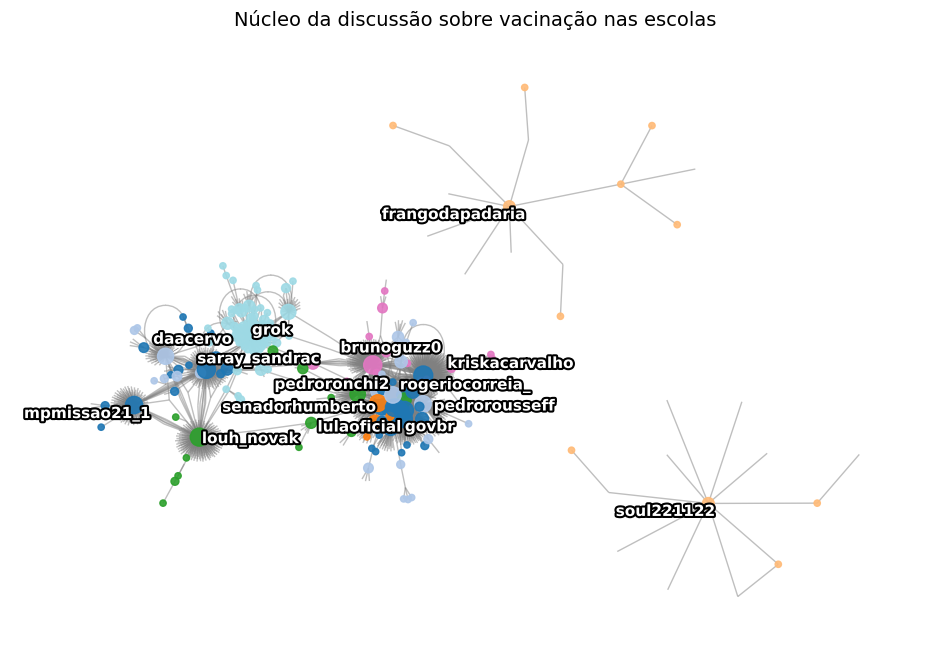

In [35]:
# ----------------------
# Módulo 23: Visualização compacta e destacada para núcleos
# ----------------------

def visualizar_nucleos_compactos(grafo, df_nos, posicionamento, comunidades, salvar=False, n_comunidades=15):
    """
    Visualiza os clusters principais com foco visual: nós maiores, imagem menor e arestas mais visíveis.
    """
    grafo_vis = grafo.to_undirected()

    # Recalcular métricas (caso o grafo seja subgrafo)
    intermediacao = nx.betweenness_centrality(grafo_vis, normalized=True)
    df_nos["intermediacao"] = df_nos["id"].map(intermediacao)
    df_nos["comunidade"] = df_nos["id"].map(comunidades)

    # Ajusta tamanho dos nós (mais visível)
    tamanho_nos = [np.log1p(df_nos.set_index("id").get("mencoes").get(no, 1)) * 30 for no in grafo_vis.nodes()]
    cores = [comunidades.get(no, 0) for no in grafo_vis.nodes()]

    # Rótulos dos líderes de comunidade
    maiores_comunidades = df_nos["comunidade"].value_counts().head(n_comunidades).index.tolist()
    top_por_comunidade = (
        df_nos[df_nos["comunidade"].isin(maiores_comunidades)]
        .groupby("comunidade")
        .apply(lambda g: g.sort_values("intermediacao", ascending=False).head(1))
        .reset_index(drop=True)
    )

    rotulos = {
        no: dados["label"]
        for no, dados in grafo_vis.nodes(data=True)
        if dados.get("label") in top_por_comunidade["label"].values
    }

    # Visualização
    plt.figure(figsize=(12, 8))  # imagem menor e mais focada
    nx.draw_networkx_nodes(
        grafo_vis,
        pos=posicionamento,
        node_color=cores,
        node_size=tamanho_nos,
        cmap=plt.cm.tab20,
        alpha=0.9
    )
    nx.draw_networkx_edges(
        grafo_vis,
        pos=posicionamento,
        alpha=0.50,         # mais visível
        width=1,          # mais espesso
        edge_color="gray"
    )

    textos = []
    for no, label in rotulos.items():
        if no in posicionamento:
            x, y = posicionamento[no]
            txt = plt.text(
                x, y, label,
                fontsize=11,
                fontweight="bold",
                color="white",
                ha="center",
                va="center",
                zorder=10
            )
            txt.set_path_effects([
                path_effects.Stroke(linewidth=3, foreground='black'),
                path_effects.Normal()
            ])
            textos.append(txt)

    adjust_text(textos, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

    plt.title("Núcleo da discussão sobre vacinação nas escolas", fontsize=14)
    plt.axis("off")

    if salvar:
        plt.savefig("rede_nucleos_compacta.png", dpi=300, bbox_inches="tight")

    plt.show()

# Subgrafo com as 5 maiores comunidades
subgrafo_nucleos = filtrar_maiores_comunidades(grafo, df_nos, comunidades, n=15)
pos_nucleos = gerar_posicionamento_graphviz(subgrafo_nucleos)

# Nova visualização destacada
visualizar_nucleos_compactos(subgrafo_nucleos, df_nos, pos_nucleos, comunidades)

